In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
from scipy import stats
import random
from scipy.signal import find_peaks

In [2]:
root_dir = "../DataBarCrawl/"
list_dir =sorted(os.listdir(root_dir))
list_dir

['README.txt',
 'all_accelerometer_data_pids_13.csv',
 'clean_tac',
 'phone_types.csv',
 'pids.txt',
 'raw_tac']

In [3]:
os.chdir(root_dir)
dataFile = list_dir[1]
data = pd.read_csv(dataFile)
data.head()

,time,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163


In [4]:
data.shape

(14057567, 5)

In [5]:
data['time'].dtype

dtype('int64')

## Clean data and drop rows where timestamp is 0 . Order the data in ascending order of user and timestamp

In [6]:
data = data[data['time'] != 0]
data = data.sort_values(by=['pid','time'],ignore_index=True)

In [7]:
data.head()

,time,pid,x,y,z
0,1493735870653,BK7610,0.1261,-0.0078,-0.0243
1,1493735870679,BK7610,0.1336,-0.0697,-0.0446
2,1493735870703,BK7610,0.1443,-0.0474,-0.0447
3,1493735870729,BK7610,0.1255,-0.0038,0.0111
4,1493735870753,BK7610,0.1076,0.0032,0.0276


## Read the TAC readings file

In [8]:
os.chdir(root_dir)
tac_dir = "/clean_tac"
os.chdir(root_dir + tac_dir)
tacLsdir = os.listdir()
tacs = {}
for pid_csv in tacLsdir:
    pid = pid_csv[:6]
    # print(pid)
    tacs[pid] = pd.read_csv(pid_csv)

In [9]:
# tacs
pid_acc_data={}
pids = list(tacs.keys())
for pid in pids:
    pid_acc_data[pid] = data[data['pid']==pid]

In [10]:
pid_acc_data['BK7610']

,time,pid,x,y,z
0,1493735870653,BK7610,0.1261,-0.0078,-0.0243
1,1493735870679,BK7610,0.1336,-0.0697,-0.0446
2,1493735870703,BK7610,0.1443,-0.0474,-0.0447
3,1493735870729,BK7610,0.1255,-0.0038,0.0111
4,1493735870753,BK7610,0.1076,0.0032,0.0276
...,...,...,...,...,...
1225722,1493767770540,BK7610,-0.0784,-0.0161,0.1719
1225723,1493767770564,BK7610,-0.0395,-0.0816,0.1634
1225724,1493767770590,BK7610,0.0160,-0.0853,0.0906
1225725,1493767770614,BK7610,0.0901,-0.0767,0.0162


In [11]:
all_data = []
for pid in pids:
    df1 = tacs[pid]
#     Shift TAC reading by 45 minutes before merging with accelerometer data
    # df1['shift_timestamp'] = df1['timestamp'] - (45*60)
    df2 = data[data['pid']==pid]
#     Change timestamp in accelerometer data from milisec to sec
    df2['timestamp'] = df2['time']//1000 
#     Merge the TAC reading and accelerometer data on timestamp
    tmp = df1.merge(df2, on= 'timestamp')
    tmp['label'] = np.where(tmp['TAC_Reading']<0.08, 0, 1)

    all_data.append(tmp)
large_df = pd.concat(all_data)

<ipython-input-11-743ea1c55821>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'] = df2['time']//1000


In [12]:
large_df.head()

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493737046,0.065357,1493737046023,BK7610,0.1410,-0.2686,-0.1372,0
1,1493737046,0.065357,1493737046063,BK7610,0.1714,-0.2722,-0.1208,0
2,1493737046,0.065357,1493737046073,BK7610,0.3328,-0.1353,-0.2548,0
3,1493737046,0.065357,1493737046101,BK7610,0.2822,-0.0375,-0.2816,0
4,1493737046,0.065357,1493737046134,BK7610,0.1847,0.1813,-0.2680,0


<ipython-input-13-170ba00cb360>:3: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=large_df[large_df['pid']=="BK7610"])
<ipython-input-13-170ba00cb360>:4: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=large_df[large_df['pid']=="BK7610"])


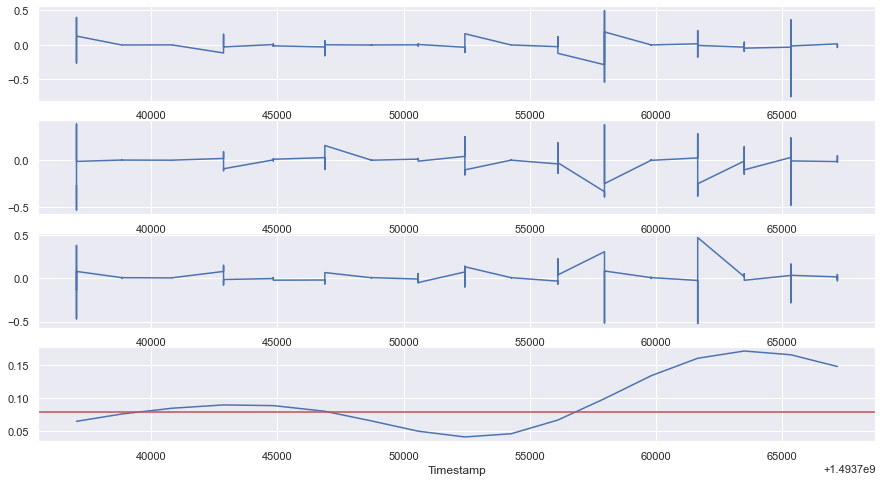

In [13]:
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=large_df[large_df['pid']=="BK7610"])
ax[1].plot("timestamp","y",data=large_df[large_df['pid']=="BK7610"])
ax[2].plot("timestamp","z",data=large_df[large_df['pid']=="BK7610"])
ax[3].plot("timestamp",'TAC_Reading', data=large_df[large_df['pid']=="BK7610"])
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

In [14]:
large_df.timestamp.dtype

dtype('int64')

##  Sampling for 800 rows -> 20 seconds of timestamp 

<ipython-input-15-cb14841ac0ac>:5: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=zoomed)
<ipython-input-15-cb14841ac0ac>:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=zoomed)


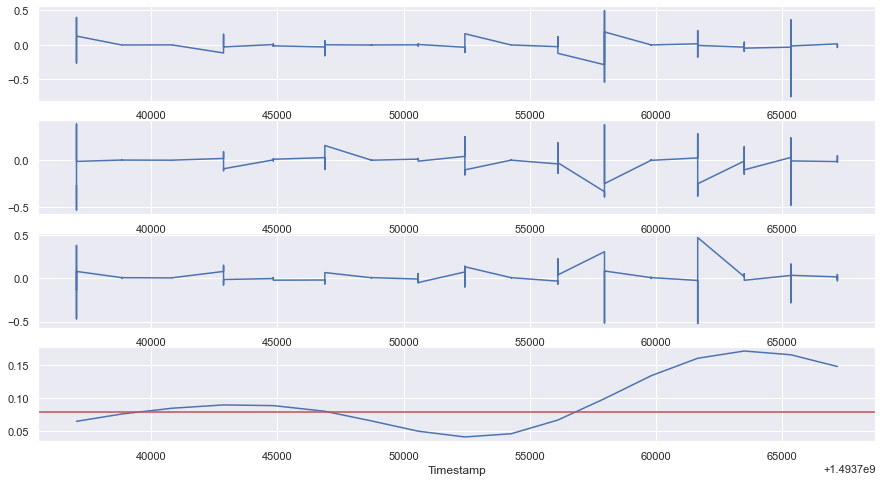

In [15]:
BK7 = large_df[large_df['pid']=="BK7610"]
zoomed = BK7[:800]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=zoomed)
ax[1].plot("timestamp","y",data=zoomed)
ax[2].plot("timestamp","z",data=zoomed)
ax[3].plot("timestamp",'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

<ipython-input-22-19629a461386>:7: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot(time,"x",data=zoomed)
<ipython-input-22-19629a461386>:9: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot(time,"y",data=zoomed)


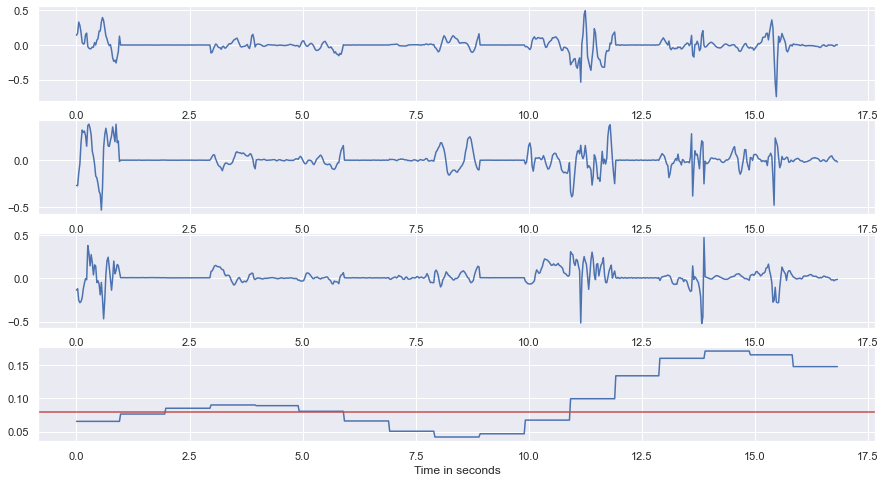

In [22]:
sampling_freq = 40
BK7 = large_df[large_df['pid']=="BK7610"]
zoomed = BK7[:800]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Time in seconds")
time = np.arange(zoomed['x'].size)/sampling_freq
ax[0].plot(time,"x",data=zoomed)
# ax[0].label(y="x axis")
ax[1].plot(time,"y",data=zoomed)
# plt.ylabel("y axis")
ax[2].plot(time,"z",data=zoomed)
# plt.ylabel("z axis")
ax[3].plot(time,'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

Zooming on 10 seconds

<ipython-input-23-c8f1ed5c67c7>:4: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=zoomed)
<ipython-input-23-c8f1ed5c67c7>:5: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=zoomed)


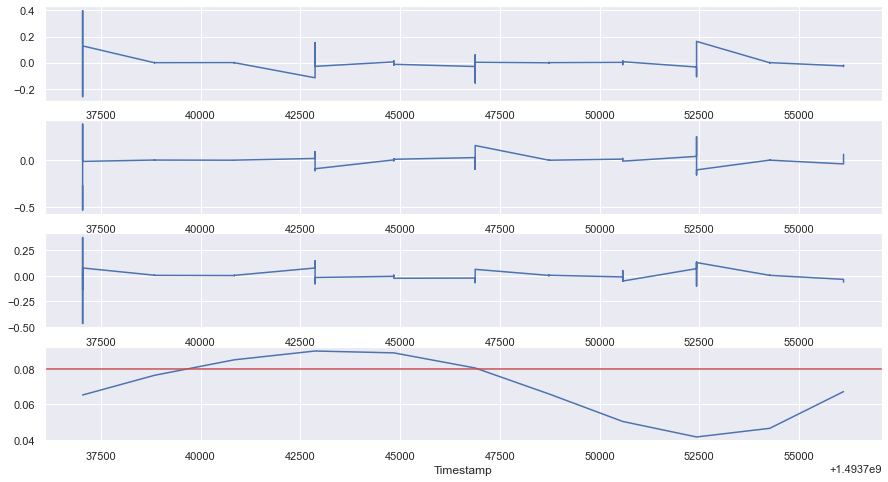

In [23]:
zoomed = BK7[:400]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=zoomed)
ax[1].plot("timestamp","y",data=zoomed)
ax[2].plot("timestamp","z",data=zoomed)
ax[3].plot("timestamp",'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

<ipython-input-24-e2abf304d28f>:5: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot(time,"x",data=zoomed)
<ipython-input-24-e2abf304d28f>:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot(time,"y",data=zoomed)


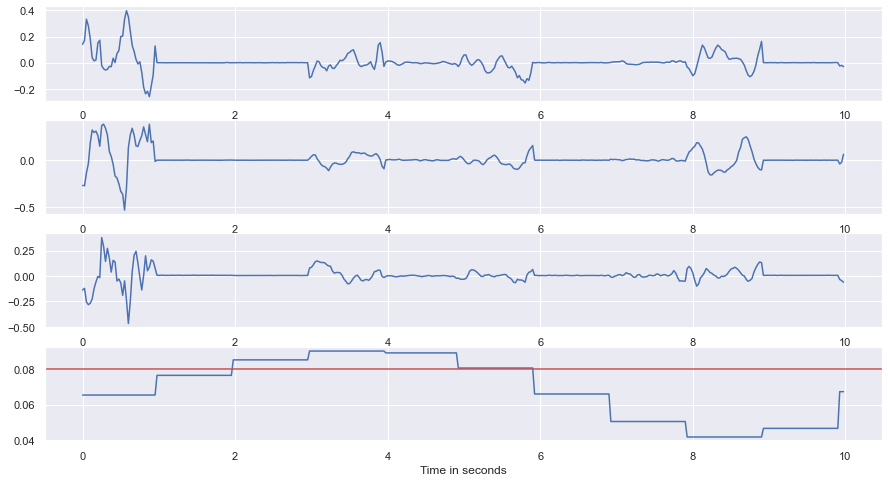

In [24]:
sampling_freq = 40
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Time in seconds")
time = np.arange(zoomed['x'].size)/sampling_freq
ax[0].plot(time,"x",data=zoomed)
ax[1].plot(time,"y",data=zoomed)
ax[2].plot(time,"z",data=zoomed)
ax[3].plot(time,'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

### Spliting Training & Test according to participants

In [25]:
participants = list(pids)
print(participants)

['BK7610', 'BU4707', 'CC6740', 'DC6359', 'DK3500', 'HV0618', 'JB3156', 'JR8022', 'MC7070', 'MJ8002', 'PC6771', 'SA0297', 'SF3079']


In [28]:
random.seed(100)
def Diff(li1, li2):
  return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [29]:
p_tr_index = random.sample(range(1, 13), 9)  # 70%13 = 9.1~9
p_te_index = Diff(list(range(1, 13)),p_tr_index)  #30%13 = 3.9~4

In [30]:
p_tr_index

[3, 8, 11, 12, 7, 6, 9, 4, 1]

In [31]:
p_te=[]
p_tr = []
for index in p_tr_index:
    p_tr.append(participants[index])
for index in p_te_index:
    p_te.append(participants[index])

In [32]:
p_tr

['DC6359',
 'MC7070',
 'SA0297',
 'SF3079',
 'JR8022',
 'JB3156',
 'MJ8002',
 'DK3500',
 'BU4707']

In [33]:
df_train = pd.DataFrame()
for pid in p_tr:
    tmp = large_df[large_df["pid"]==pid]
    df_train = df_train.append(tmp)

In [34]:
df_train

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493748079,0.122072,1493748079007,DC6359,0.0081,-0.0063,-0.0106,1
1,1493748079,0.122072,1493748079039,DC6359,0.0069,-0.0109,-0.0092,1
2,1493748079,0.122072,1493748079059,DC6359,-0.0012,-0.0004,0.0076,1
3,1493748079,0.122072,1493748079097,DC6359,-0.0098,0.0121,-0.0065,1
4,1493748079,0.122072,1493748079118,DC6359,-0.0103,0.0298,0.0124,1
...,...,...,...,...,...,...,...,...
232,1493754265,0.046559,1493754265899,BU4707,-0.1110,0.0593,-0.0076,0
233,1493754265,0.046559,1493754265924,BU4707,-0.0346,0.0581,0.0428,0
234,1493754265,0.046559,1493754265949,BU4707,-0.0171,0.0288,0.0553,0
235,1493754265,0.046559,1493754265974,BU4707,-0.0354,-0.0062,0.0595,0


In [35]:
df_test = pd.DataFrame()
for pid in p_te:
    tmp = large_df[large_df["pid"]==pid]
    df_test = df_test.append(tmp)

In [36]:
df_test

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493741188,0.041870,1493741188015,CC6740,-4.696118,-16.039703,6.315768,0
1,1493741188,0.041870,1493741188039,CC6740,-8.342324,-6.281204,-9.354126,0
2,1493741188,0.041870,1493741188065,CC6740,-6.992756,-1.318486,-8.665682,0
3,1493741188,0.041870,1493741188089,CC6740,-6.556036,1.632029,-3.295139,0
4,1493741188,0.041870,1493741188217,CC6740,-7.352158,2.141843,2.943863,0
...,...,...,...,...,...,...,...,...
595,1493805699,0.006193,1493805699881,HV0618,-0.001300,0.000000,0.006300,0
596,1493805699,0.006193,1493805699905,HV0618,-0.001000,-0.000100,0.007500,0
597,1493805699,0.006193,1493805699932,HV0618,-0.001100,-0.000600,0.006100,0
598,1493805699,0.006193,1493805699957,HV0618,-0.001300,0.000200,0.007100,0


# Window size = 5 seconds 
5 seconds = 40*5 samples = 200 samples
<br>
step_size = 25 (Since the data is taken at 25 miliseconds)

In [37]:
x_list = []
y_list = []
z_list = []
train_labels = []
window_size = 200
step_size = 25

for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x'].values[i: i + 200]
    ys = df_train['y'].values[i: i + 200]
    zs = df_train['z'].values[i: i + 200]
    label = stats.mode(df_train['label'][i: i + 200])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [38]:
len(train_labels)

124

In [39]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

In [40]:
# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/200)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/200)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/200))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/200)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/200)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/200))

In [41]:
X_train

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness,z_skewness,x_kurtosis,y_kurtosis,z_kurtosis,x_energy,y_energy,z_energy,avg_result_accl,sma
0,0.002858,-0.004241,0.001358,0.019215,0.015764,0.022025,0.011005,0.009745,0.015183,-0.0912,...,1.237656,-0.060987,7.819703,8.777219,1.991038,0.000377,0.000266,0.000487,0.024102,0.036593
1,0.001722,-0.003740,0.002285,0.018506,0.014564,0.021579,0.010004,0.008475,0.014171,-0.0912,...,1.668557,-0.195743,8.833924,11.829341,2.367811,0.000345,0.000226,0.000471,0.022324,0.033809
2,0.001029,-0.003508,0.002052,0.018321,0.014454,0.021655,0.009474,0.008255,0.014526,-0.0912,...,1.681576,-0.136619,9.107801,12.153048,2.300647,0.000337,0.000221,0.000473,0.021976,0.033131
3,-0.003733,0.000265,-0.001616,0.029723,0.025888,0.030546,0.015491,0.012638,0.018555,-0.1488,...,3.332516,-2.578019,8.180174,14.849228,14.892888,0.000897,0.000670,0.000936,0.029397,0.044948
4,-0.011624,0.008930,0.000775,0.037393,0.034100,0.035972,0.025434,0.022793,0.021714,-0.1488,...,2.043923,-1.402722,2.780519,4.492727,8.592464,0.001533,0.001243,0.001295,0.039539,0.060952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-0.000350,0.018479,0.010260,0.061192,0.082895,0.054999,0.032447,0.049970,0.030843,-0.2881,...,0.811622,0.418227,4.877566,5.288963,4.994918,0.003745,0.007213,0.003130,0.071457,0.103748
120,-0.000559,0.020861,0.015734,0.062241,0.087968,0.063086,0.035408,0.057486,0.041939,-0.2881,...,0.635495,0.296320,4.397806,3.737297,2.410649,0.003874,0.008174,0.004227,0.085698,0.124480
121,-0.000549,0.021136,0.015516,0.062459,0.088120,0.064819,0.036708,0.057673,0.044871,-0.2881,...,0.620938,0.281745,4.296350,3.684501,1.933857,0.003901,0.008212,0.004442,0.089574,0.130474
122,0.002319,0.023252,0.015863,0.060848,0.087874,0.065597,0.034937,0.058241,0.046482,-0.2881,...,0.565362,0.246311,4.994550,3.693414,1.719981,0.003708,0.008263,0.004555,0.091158,0.132755


In [42]:
len(x_list)

124

# Fourier Transform

C:\Users\shubh\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


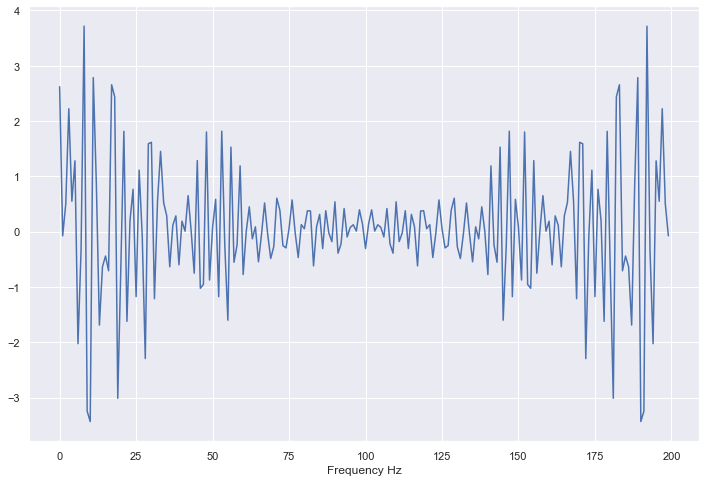

In [43]:
pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.xlabel("Frequency Hz")
plt.show()

##### the signal is symmetric about the center, so we can take only first half of the wave

C:\Users\shubh\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


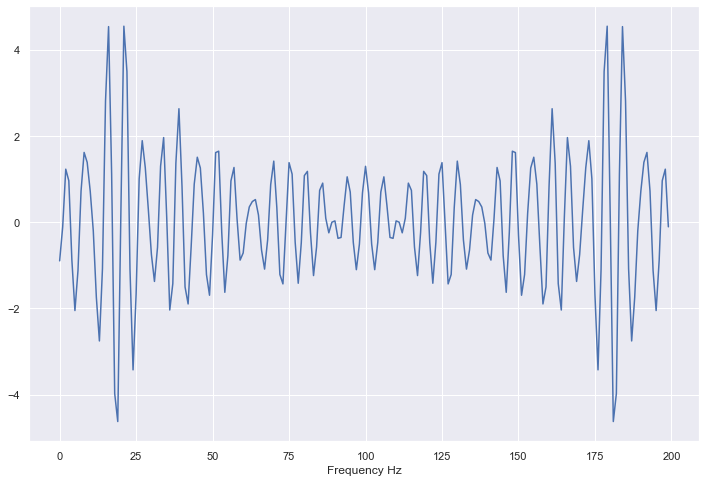

In [44]:
pd.Series(np.fft.fft(pd.Series(x_list)[25])).plot()
plt.xlabel("Frequency Hz")
plt.show()

In [45]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [46]:
X_train

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness_fft,z_skewness_fft,x_kurtosis_fft,y_kurtosis_fft,z_kurtosis_fft,x_energy_fft,y_energy_fft,z_energy_fft,avg_result_accl_fft,sma_fft
0,0.002858,-0.004241,0.001358,0.019215,0.015764,0.022025,0.011005,0.009745,0.015183,-0.0912,...,0.300536,0.259187,-1.146063,-0.248213,-1.091532,0.243707,0.135577,0.341467,0.804457,1.265199
1,0.001722,-0.003740,0.002285,0.018506,0.014564,0.021579,0.010004,0.008475,0.014171,-0.0912,...,-0.073459,0.257871,-0.673796,-0.450754,-1.203549,0.227921,0.123548,0.342067,0.784182,1.249293
2,0.001029,-0.003508,0.002052,0.018321,0.014454,0.021655,0.009474,0.008255,0.014526,-0.0912,...,-0.462789,0.332055,-0.596763,-0.216832,-1.155324,0.223253,0.122352,0.341494,0.780966,1.243338
3,-0.003733,0.000265,-0.001616,0.029723,0.025888,0.030546,0.015491,0.012638,0.018555,-0.1488,...,0.346387,0.675058,-1.148881,-1.201094,-0.531643,0.594482,0.377456,0.632556,1.180977,1.929531
4,-0.011624,0.008930,0.000775,0.037393,0.034100,0.035972,0.025434,0.022793,0.021714,-0.1488,...,1.402281,0.852368,0.997793,1.023430,-0.116842,0.977272,0.727381,0.812065,1.396752,2.238430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-0.000350,0.018479,0.010260,0.061192,0.082895,0.054999,0.032447,0.049970,0.030843,-0.2881,...,-0.082356,0.442940,-0.567875,-0.945515,0.016954,2.141773,4.600810,1.979207,2.889011,4.534597
120,-0.000559,0.020861,0.015734,0.062241,0.087968,0.063086,0.035408,0.057486,0.041939,-0.2881,...,-0.053325,0.105604,-0.150558,-1.037786,-0.694111,2.153925,5.232413,2.669463,3.049561,4.819731
121,-0.000549,0.021136,0.015516,0.062459,0.088120,0.064819,0.036708,0.057673,0.044871,-0.2881,...,0.039667,0.284557,-0.186573,-1.030109,-0.701606,2.166747,5.241466,2.779785,3.075252,4.860309
122,0.002319,0.023252,0.015863,0.060848,0.087874,0.065597,0.034937,0.058241,0.046482,-0.2881,...,0.237166,0.479445,-1.096429,-0.825869,-0.508904,2.010287,5.191379,2.820235,3.057522,4.812796


# Transform the X_test similarly

In [47]:
x_list = []
y_list = []
z_list = []
test_labels = []
window_size = 200
step_size = 25

for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x'].values[i: i + 200]
    ys = df_test['y'].values[i: i + 200]
    zs = df_test['z'].values[i: i + 200]
    label = stats.mode(df_test['label'][i: i + 200])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

In [48]:
len(test_labels)

80

In [49]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

In [50]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/200)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/200)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/200))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/200)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/200)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/200))

In [51]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [52]:
X_test.shape

(80, 94)

In [53]:
X_train.shape

(124, 94)

# Logistic Model


In [54]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [55]:
len(y_test)

80

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8625

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.97      0.88      0.93        78
           1       0.00      0.00      0.00         2

    accuracy                           0.86        80
   macro avg       0.49      0.44      0.46        80
weighted avg       0.95      0.86      0.90        80

